# May ??, 2022 (adj look good?)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
_fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = 'Documents/workspaces/lfr/binary_overlapping'
lfr_dir = pjoin(os.environ['HOME'], lfr_dir)

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# RABIES
sys.path.insert(0, pjoin(git_dir, 'RABIES'))
from rabies.confound_correction_pkg.utils import butterworth as rb_butter

# set style & no interpolalation
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
def show_spectogram(spect_dict, xlim=None, figsize=None, title=None, show: bool = True):
    figsize = figsize if figsize else (10, 3 * len(spect_dict))
    fig, axes = create_figure(len(spect_dict), 2, figsize, 'col', 'row', width_ratios=[1, 0.4])
    kws = {
        'vmin': min(v[-1].mean(0).min() for v in spect_dict.values()),
        'vmax': max(v[-1].mean(0).max() for v in spect_dict.values()),
        'cmap': 'Spectral_r',
        'shading': 'gouraud',
        'norm': matplotlib.colors.LogNorm()
    }
    for i, (lbl, (_f, _t, _sxx)) in enumerate(spect_dict.items()):
        _sxx = _sxx.mean(0)
        im = axes[i, 0].pcolormesh(_t, _f, _sxx, **kws)
        plt.colorbar(im, ax=axes[i, 0])

        axes[i, 1].plot(_sxx.mean(1), _f, label=lbl)
        axes[i, 1].tick_params(
            axis='y',
            which='both',
            left=True,
            right=True,
            labelleft=False,
            labelright=True,
        )
        if i == 2:
            axes[i, 0].set_xlabel('Time [s]')
            axes[i, 1].set_xlabel('Power')
        axes[i, 0].set_ylabel('Frequency [Hz]')
        axes[i, 1].set_ylabel('Frequency [Hz]', rotation=-90, labelpad=20)
        axes[i, 1].yaxis.set_label_position('right')
        axes[i, 1].legend(loc='upper right')
        axes[i, 1].set_xscale('log')
        axes[i, 1].grid()
    if xlim is not None:
        axes[-1, -1].set_xlim(*xlim)
    sup = fig.suptitle(title if title else key, fontsize=17, y=1.01)
    if show:
        plt.show()
    else:
        plt.close()
    return fig, sup

In [7]:
mice = Mice(192)

{'bold': (0.01, 0.5), 'ca2': (0.5, 5.0)}

In [8]:
gr = Group(mice=mice, perc='p250-sample', mode='ca2', key=mice.get_key(7, 3, 1))
gr.create_save_dir().split('/')

[
    '',
    'home',
    'hadi',
    'Documents',
    'Ca-fMRI',
    'processed',
    'norm-global_parcel-columnar_n-192*3',
    'results',
    'SVINET',
    'Group',
    'real_pearson_ca2_rest_bp(0.5,5.0)_k7_p250-sample'
]

In [9]:
gr = Group(mice=mice, perc='p250-sample', mode='bold-lite', key=mice.get_key(7, 3, 1))
gr.create_save_dir().split('/')

[
    '',
    'home',
    'hadi',
    'Documents',
    'Ca-fMRI',
    'processed',
    'norm-global_parcel-columnar_n-192*3',
    'results',
    'SVINET',
    'Group',
    'real_pearson_bold-lite_rest_bp(0.01,0.5)_k7_p250-sample'
]

In [4]:
task = 'rest'
kws = {
    'task': task,
    'band_ca': None,
    'band_bo': 0.01,
}
adj_ca = {}
for b in [0.01, 0.5, (0.01, 0.5)]:
    kws['band_ca'] = b
    _a, dirs_ca = collect_adjacencies(mice, 'ca2', **kws)
    adj_ca[f"{b}_task-{task}"] = _a

In [5]:
b = 0.01
kws = {
    'task': task,
    'band_bo': b,
}
adj_bo = {}
_a, dirs_bo = collect_adjacencies(mice, 'bold-lite', **kws)
adj_bo[f"{b}_task-{task}"] = _a

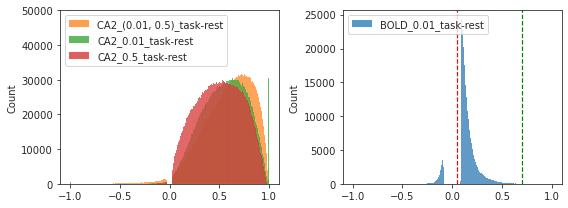

In [127]:
fig, axes = create_figure(1, 2, (8, 3), 'all')
for i, (lbl, a) in enumerate(sorted(adj_ca.items())):
    sns.histplot(a[a.nonzero()], label=f'CA2_{lbl}', color=f'C{i + 1}', ax=axes[0])
for lbl, a in adj_bo.items():
    sns.histplot(a[a.nonzero()], label=f'BOLD_{lbl}', ax=axes[1])
# axes[0].axvline(-0.5, color='r', ls='--', lw=1.2)
axes[1].axvline(0.05, color='r', ls='--', lw=1.2)
axes[1].axvline(0.70, color='g', ls='--', lw=1.2)
axes[0].set_ylim(0, 50000)
for ax in axes.flat:
    ax.legend()
plt.show()

In [129]:
rho = [0.1, 0.2, 0.25]

adj_ca_binary = {}
for lbl, a in adj_ca.items():
    a_bin = np_nans((len(rho), *a.shape))
    for i, _a in enumerate(a):
        thresholds = calculate_threshold(_a, rho)
        for j, (d, th) in enumerate(zip(rho, thresholds)):
            _b = _a.copy()
            _b[_a <= th] = 0
            _b[_a > th] = 1
            a_bin[j, i] = _b
    adj_ca_binary[lbl] = a_bin
    
adj_bo_binary = {}
for lbl, a in adj_bo.items():
    a_bin = np_nans((len(rho), *a.shape))
    for i, _a in enumerate(a):
        thresholds = calculate_threshold(_a, rho)
        for j, (d, th) in enumerate(zip(rho, thresholds)):
            _b = _a.copy()
            _b[_a <= th] = 0
            _b[_a > th] = 1
            a_bin[j, i] = _b
    adj_bo_binary[lbl] = a_bin
    
deg_ca = {lbl: bn.nansum(x, -1) for lbl, x in adj_ca_binary.items()}
deg_bo = {lbl: bn.nansum(x, -1) for lbl, x in adj_bo_binary.items()}

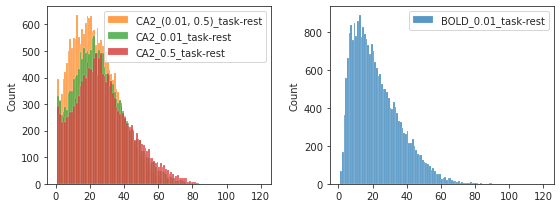

In [137]:
fig, axes = create_figure(1, 2, (8, 3), 'all')
j = 0
for i, (lbl, x) in enumerate(sorted(deg_ca.items())):
    sns.histplot(x[j][x[j].nonzero()],
                 label=f'CA2_{lbl}',
                 color=f'C{i + 1}',
                 bins=np.linspace(1, 120, 120),
                 ax=axes[0],
                )
for i, (lbl, x) in enumerate(sorted(deg_bo.items())):
    sns.histplot(x[j][x[j].nonzero()],
                 label=f'BOLD_{lbl}',
                 color=f'C0',
                 bins=np.linspace(1, 120, 120),
                 ax=axes[1],
                )

# axes[0].axvline(2, color='r', ls='--', lw=1.2)
# axes[0].axvline(45, color='g', ls='--', lw=1.2)
# axes[1].axvline(2, color='r', ls='--', lw=1.2)
# axes[1].axvline(45, color='g', ls='--', lw=1.2)
for ax in axes.flat:
    ax.legend()
plt.show()

In [138]:
deg_ca_avg = {lbl: bn.nansum(bn.nanmean(x, 1), -1) for lbl, x in adj_ca_binary.items()}
deg_bo_avg = {lbl: bn.nansum(bn.nanmean(x, 1), -1) for lbl, x in adj_bo_binary.items()}

<AxesSubplot:ylabel='Count'>

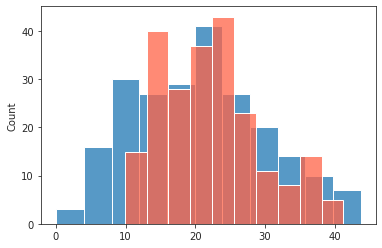

In [147]:
sns.histplot(deg_ca_avg['(0.01, 0.5)_task-rest'][0])
sns.histplot(deg_bo_avg['0.01_task-rest'][0], color='tomato')

In [148]:
deg_ca_avg['0.01_task-rest'].shape

(3, 224)

In [190]:
gr = Group(mice=mice, mode='ca2')

In [208]:
j = 0
tr_ca = gr.project_vec(deg_ca_avg['(0.01, 0.5)_task-rest'][j], add_disjoint=False)
tr_bo = gr.project_vec(deg_bo_avg['0.01_task-rest'][j], add_disjoint=False)
tr_ca = gr.trim2d(tr_ca)
tr_bo = gr.trim2d(tr_bo)

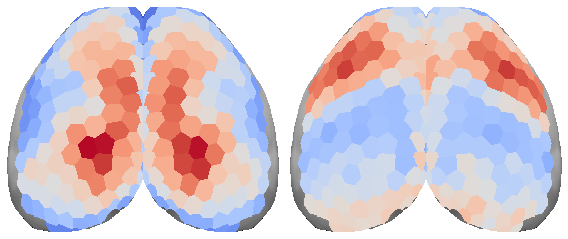

In [211]:
fig, axes = create_figure(1, 2, (8, 3.5))

axes[0].imshow(mwh(tr_ca['top'] == 0, tr_ca['top']), cmap='Greys_r')
axes[0].imshow(mwh(tr_ca['proj-top'][0] == 0, tr_ca['proj-top'][0]), cmap='coolwarm', vmin=0, vmax=44)

axes[1].imshow(mwh(tr_bo['top'] == 0, tr_bo['top']), cmap='Greys_r')
axes[1].imshow(mwh(tr_bo['proj-top'][0] == 0, tr_bo['proj-top'][0]), cmap='coolwarm', vmin=0, vmax=44)
remove_ticks(axes)
plt.show()

In [212]:
j = 2
tr_ca = gr.project_vec(deg_ca_avg['(0.01, 0.5)_task-rest'][j], add_disjoint=False)
tr_bo = gr.project_vec(deg_bo_avg['0.01_task-rest'][j], add_disjoint=False)
tr_ca = gr.trim2d(tr_ca)
tr_bo = gr.trim2d(tr_bo)

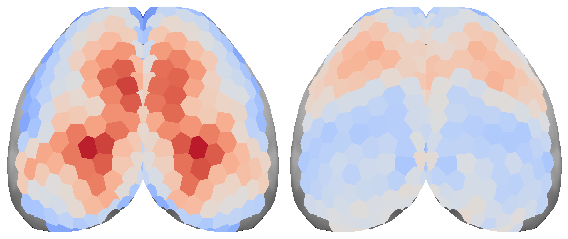

In [213]:
fig, axes = create_figure(1, 2, (8, 3.5))

axes[0].imshow(mwh(tr_ca['top'] == 0, tr_ca['top']), cmap='Greys_r')
axes[0].imshow(mwh(tr_ca['proj-top'][0] == 0, tr_ca['proj-top'][0]), cmap='coolwarm', vmin=0, vmax=100)

axes[1].imshow(mwh(tr_bo['top'] == 0, tr_bo['top']), cmap='Greys_r')
axes[1].imshow(mwh(tr_bo['proj-top'][0] == 0, tr_bo['proj-top'][0]), cmap='coolwarm', vmin=0, vmax=100)
remove_ticks(axes)
plt.show()

In [224]:
j = 2
tr_ca = gr.project_vec(deg_ca_avg['0.5_task-rest'][j], add_disjoint=False)
tr_bo = gr.project_vec(deg_bo_avg['0.01_task-rest'][j], add_disjoint=False)
tr_ca = gr.trim2d(tr_ca)
tr_bo = gr.trim2d(tr_bo)

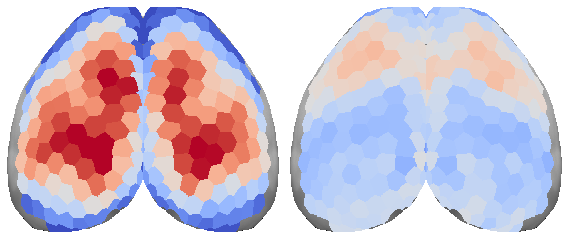

In [228]:
fig, axes = create_figure(1, 2, (8, 3.5))

axes[0].imshow(mwh(tr_ca['top'] == 0, tr_ca['top']), cmap='Greys_r')
axes[0].imshow(mwh(tr_ca['proj-top'][0] == 0, tr_ca['proj-top'][0]), cmap='coolwarm', vmin=10, vmax=100)

axes[1].imshow(mwh(tr_bo['top'] == 0, tr_bo['top']), cmap='Greys_r')
axes[1].imshow(mwh(tr_bo['proj-top'][0] == 0, tr_bo['proj-top'][0]), cmap='coolwarm', vmin=10, vmax=100)
remove_ticks(axes)
plt.show()

In [236]:
i = list(dirs_ca).index(mice.get_key(4, 2, 7))
x = adj_ca['0.5_task-rest'][i]

In [237]:
x.shape

(224, 224)

In [246]:
j = 1
x = adj_ca_binary['0.5_task-rest'][j, i]

<matplotlib.image.AxesImage object at 0x7f37e74d8730>

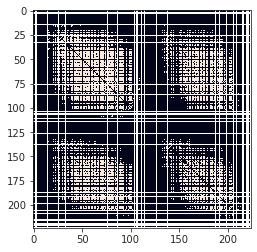

In [247]:
plt.imshow(x)

In [251]:
valid = bn.nansum(x, 0) > 0
valid.sum()

129

In [254]:
128 * 129 / 192

86.0

<matplotlib.image.AxesImage object at 0x7f37e1dbb430>

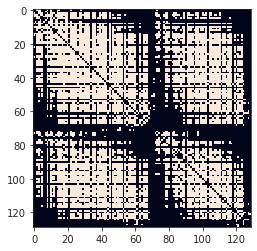

In [255]:
plt.imshow(x[valid][:, valid])

In [4]:
key = 'sub-SLC06_ses-3_run-3'
_k = mice.get_key(*mice.looper[key][:2])

nperseg = 512
spect_dict = {}

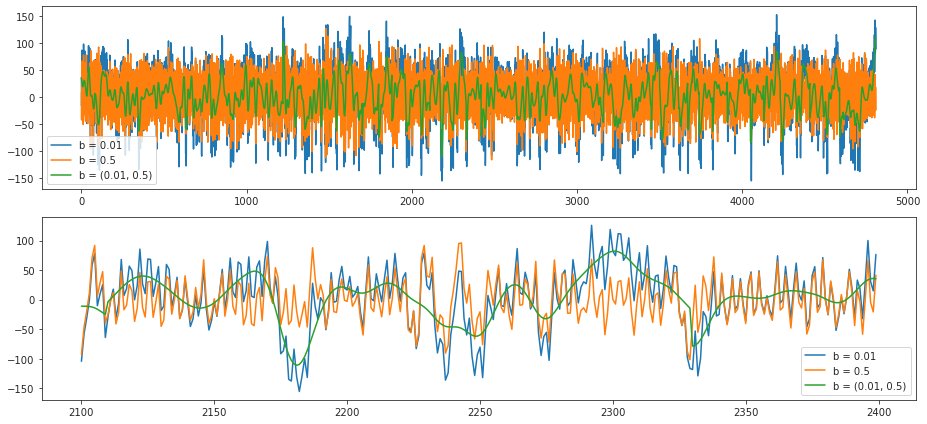

In [5]:
fig, axes = create_figure(2, 1, (13, 6))
for b in [0.01, 0.5, (0.01, 0.5)]:
    mice.setup_func_data(
        task='rest',
        runs_only=True,
        band_ca=b,
    )
    x = mice.ca['sub-SLC06_ses-3_run-3'][:]
    good_nodes = np.isnan(x).sum(1) == 0
    x = x[good_nodes]
    
    spect_dict[f"ca2_b={b}".replace(' ', '')] = sp_sig.spectrogram(
        x, 10, nperseg=nperseg)

    axes[0].plot(bn.nanmean(x, 0), label=f"b = {b}")
    axes[1].plot(range(2100, 2400), bn.nanmean(x, 0)[2100:2400], label=f"b = {b}")
    
axes[0].legend()
axes[1].legend()
plt.show()

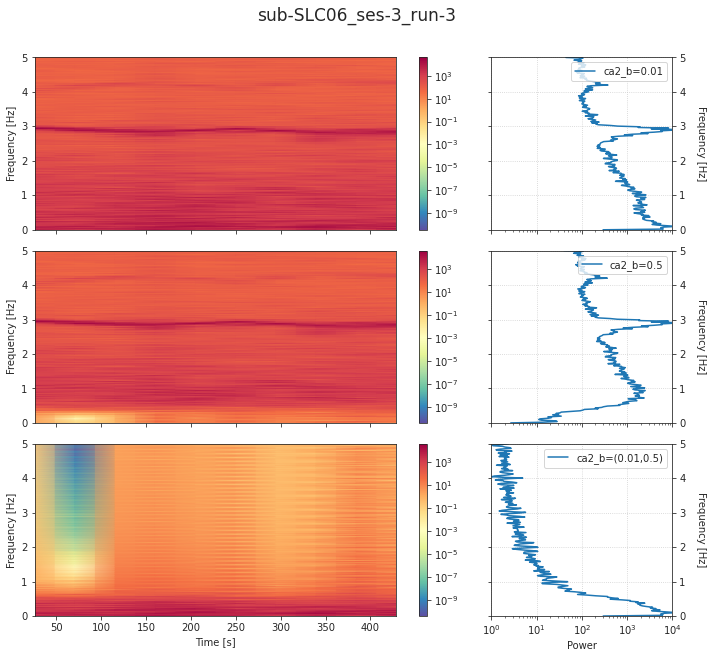

In [6]:
_ = show_spectogram(spect_dict, (1e0, 1e4))

In [7]:
mice.setup_preproc_data()
mice.setup_anat_data()

In [8]:
m_indiv = mice.mask2d[_k].load_ants()
m_indiv = m_indiv.numpy().astype(bool)
x_pre = mice.ca_preproc[key].load_ants().numpy()

In [9]:
x_pre = x_pre[m_indiv].squeeze()
x_pre = x_pre[:, 500:]
x_pre.shape

(24771, 5500)

[<matplotlib.lines.Line2D object at 0x7fe074432250>]

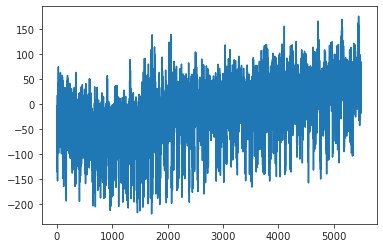

In [10]:
plt.plot(x_pre.mean(0))

In [11]:
from register.preprocess import butterworth

In [12]:
x_pre_filt = {
    b: butterworth(x_pre, b, 10) for
    b in [0.01, 0.5, (0.01, 0.5)]
}

In [13]:
for b, _x in x_pre_filt.items():
    spect_dict[f"ca2pre_b={b}".replace(' ', '')] = sp_sig.spectrogram(
        _x, 10, nperseg=nperseg)

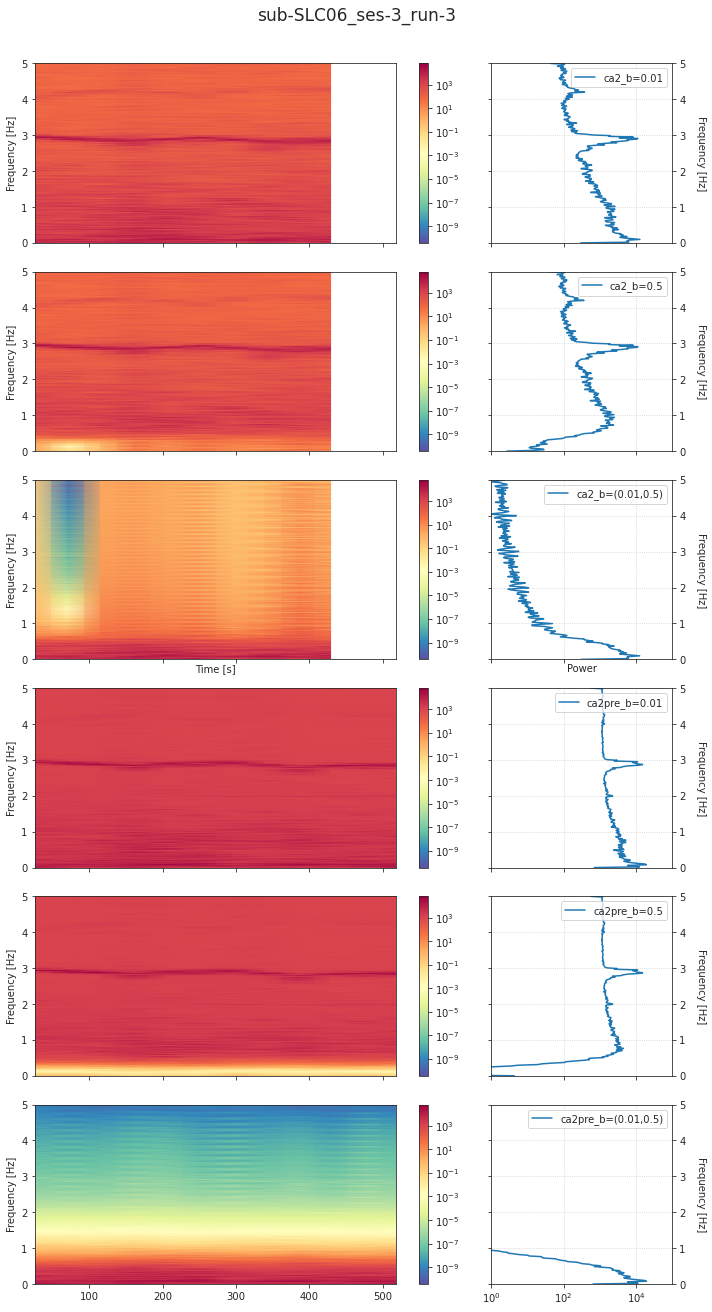

In [15]:
_ = show_spectogram(spect_dict, (1e0, 1e5))

In [16]:
df = pjoin(mice.cfg.base_dir, 'meta_info')
df = pd.read_pickle(pjoin(df, 'temporal_mask_hp.df'))
tmask = df.loc[
    df['key'] == key,
    'temporal_mask',
].values.astype(bool)
tmask[:15] = True
tmask[-15:] = True
tmask = np.repeat(tmask, 10)
tmask = tmask[500:]
tmask.shape

(5500,)

In [17]:
x_pre_filt_tmasked = {k: v[:, tmask] for k, v in x_pre_filt.items()}

In [18]:
for b, _x in x_pre_filt_tmasked.items():
    spect_dict[f"ca2pre-tmasked_b={b}".replace(' ', '')] = sp_sig.spectrogram(
        _x, 10, nperseg=nperseg)

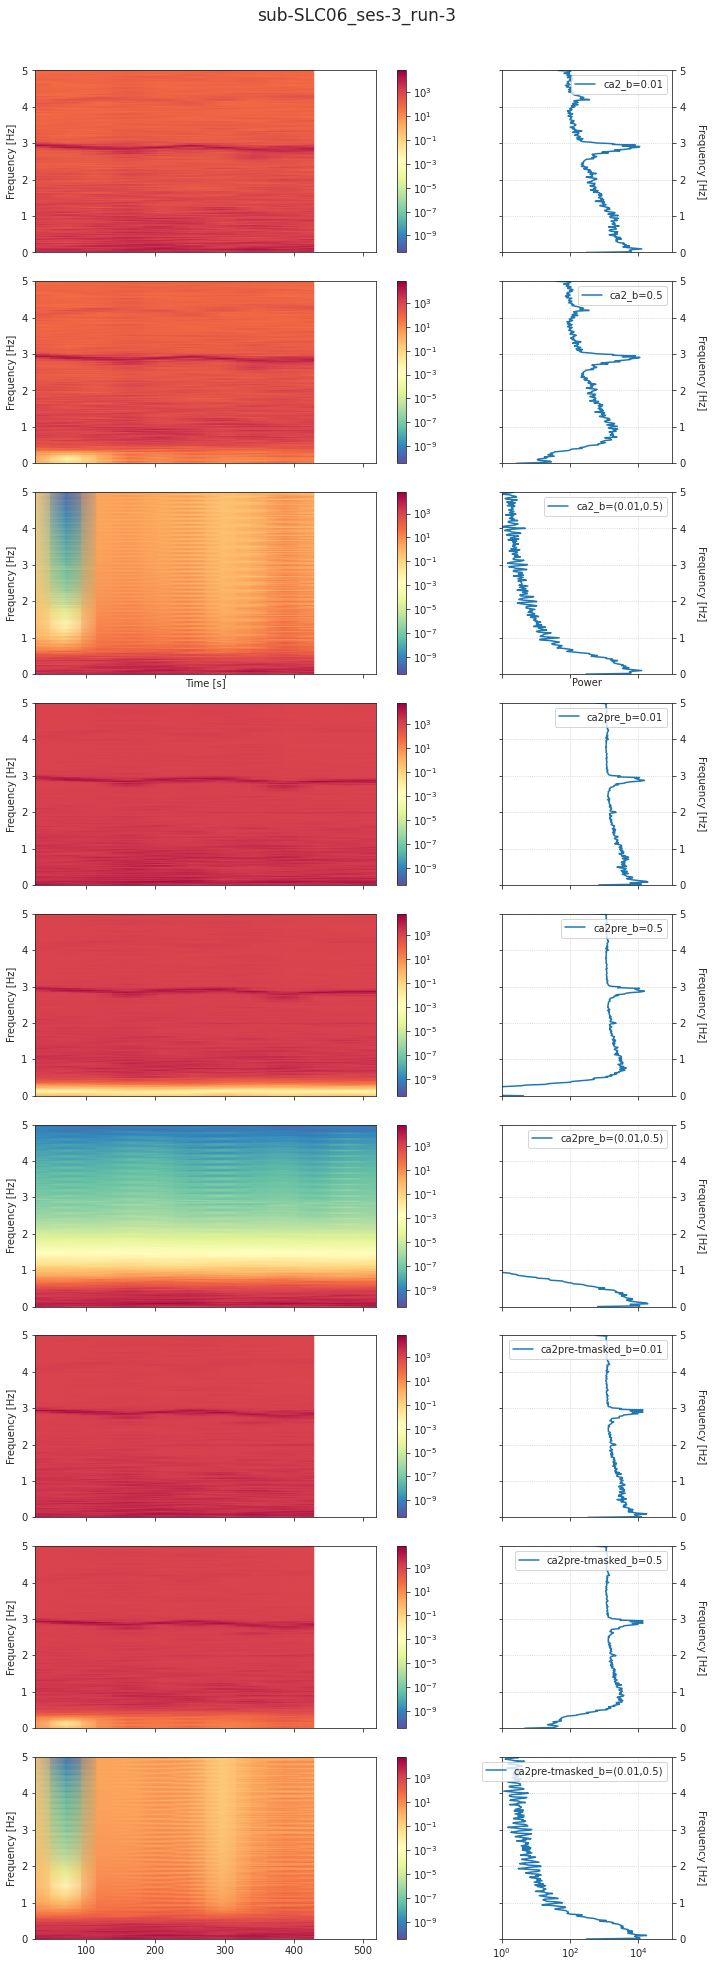

In [19]:
_ = show_spectogram(spect_dict, (1e0, 1e5))

[<matplotlib.lines.Line2D object at 0x7fe013b55b20>]

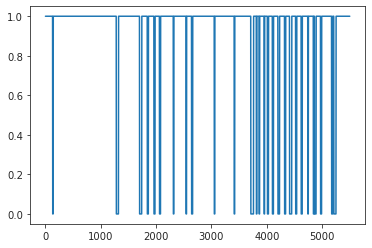

In [20]:
plt.plot(tmask)

In [29]:
net = Network(mice=mice, mode='ca2', key=key)
net.base_name

'n-192*3_bp(0.01,0.5)_ca2_rest_pearson_sub-SLC06_ses-3_run-3'

In [31]:
mice.set_band(0.01, 0.01)

In [32]:
mice.band

{'bold': (0.01, 0.5), 'ca2': (0.01, 5.0)}

In [33]:
net = Network(mice=mice, mode='ca2', key=key)
net.base_name

'n-192*3_bp(0.01,5.0)_ca2_rest_pearson_sub-SLC06_ses-3_run-3'

In [60]:
armode = 'ca2'
artask = 'all'

In [61]:
if armode == 'ca2':
    bands = [0.01, 0.5, (0.01, 0.5)]
else:
    bands = [0.01]
if artask == 'all':
    tasks = ['rest', 'led']
else:
    tasks = [artask]
looper = itertools.product(tasks, bands)
list(looper)

[
    ('rest', 0.01),
    ('rest', 0.5),
    ('rest', (0.01, 0.5)),
    ('led', 0.01),
    ('led', 0.5),
    ('led', (0.01, 0.5))
]

In [54]:
net.base_name

'n-192*3_bp(0.01,5.0)_ca2_rest_pearson_sub-SLC06_ses-3_run-3'

In [50]:
task = 'rest'
b = 0.01
msg = f"running network analysis (task = {task}, b = {b}): {key}"
print(msg)

running network analysis (task = rest, b = 0.01): sub-SLC06_ses-3_run-3

In [66]:
mice.setup_func_data(
    task='rest',
    runs_only=True,
    band_bo=0.01,
)

In [68]:
x = mice.bold[key][:]
good_nodes = np.isnan(x).sum(1) == 0
x = x[good_nodes]

In [69]:
spect_dict['bold_b=0.01'] = sp_sig.spectrogram(x, 1, nperseg=nperseg // 4)

### Why 92 nodes?

In [73]:
mice = Mice(192)
mice.setup_func_data('all')

In [74]:
good_nodes = {}
for key, func in mice.ca.items():
    x = func[:]
    if x is None:
        continue
    good = np.isnan(x).sum(1) == 0
    good_nodes[key] = good.sum()

<AxesSubplot:ylabel='Count'>

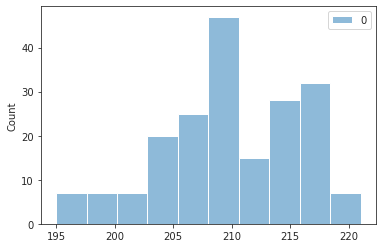

In [75]:
sns.histplot(good_nodes.values())

In [3]:
mice = Mice(128)
mice.setup_func_data('all')

In [4]:
good_nodes = {}
for key, func in mice.ca.items():
    x = func[:]
    if x is None:
        continue
    good = np.isnan(x).sum(1) == 0
    good_nodes[key] = good.sum()

<AxesSubplot:ylabel='Count'>

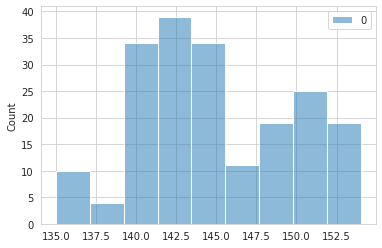

In [5]:
sns.histplot(good_nodes.values())

In [10]:
import fnmatch

In [14]:
files = sorted(fnmatch.filter(
    names=os.listdir(mice.cfg.svinet_dir),
    pat='n-128[*]3_bp*_ca2_*',
))

In [60]:
counts = {}
for f in files:
    n = os.listdir(pjoin(mice.cfg.svinet_dir, f, 'real', 'p20-sample'))
    n = next(e for e in n if '.txt' not in n)
    n = re.findall(r"\d+", n.split('-')[0])
    counts[f] = int(n.pop())

<AxesSubplot:ylabel='Count'>

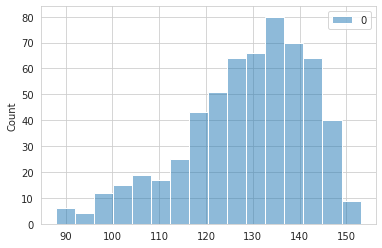

In [61]:
sns.histplot(counts.values())

In [67]:
{f: n for f, n in counts.items() if n < 100}

{
    'n-128*3_bp(0.5,5.0)_ca2_led_pearson_sub-SLC03_ses-1_run-7': 99,
    'n-128*3_bp(0.5,5.0)_ca2_led_pearson_sub-SLC03_ses-3_run-6': 94,
    'n-128*3_bp(0.5,5.0)_ca2_led_pearson_sub-SLC05_ses-1_run-4': 88,
    'n-128*3_bp(0.5,5.0)_ca2_led_pearson_sub-SLC05_ses-1_run-6': 92,
    'n-128*3_bp(0.5,5.0)_ca2_led_pearson_sub-SLC05_ses-2_run-6': 97,
    'n-128*3_bp(0.5,5.0)_ca2_led_pearson_sub-SLC05_ses-3_run-6': 94,
    'n-128*3_bp(0.5,5.0)_ca2_led_pearson_sub-SLC09_ses-1_run-4': 99,
    'n-128*3_bp(0.5,5.0)_ca2_led_pearson_sub-SLC09_ses-1_run-6': 98,
    'n-128*3_bp(0.5,5.0)_ca2_rest_pearson_sub-SLC03_ses-1_run-6': 99,
    'n-128*3_bp(0.5,5.0)_ca2_rest_pearson_sub-SLC03_ses-2_run-7': 95,
    'n-128*3_bp(0.5,5.0)_ca2_rest_pearson_sub-SLC03_ses-3_run-5': 95,
    'n-128*3_bp(0.5,5.0)_ca2_rest_pearson_sub-SLC03_ses-3_run-7': 99,
    'n-128*3_bp(0.5,5.0)_ca2_rest_pearson_sub-SLC04_ses-2_run-7': 89,
    'n-128*3_bp(0.5,5.0)_ca2_rest_pearson_sub-SLC05_ses-1_run-3': 91,
    'n-128*3_bp(0.5,5.0)_ca2_rest_pearson_sub-SLC05_ses-1_run-5': 92,
    'n-128*3_bp(0.5,5.0)_ca2_rest_pearson_sub-SLC05_ses-1_run-7': 91,
    'n-128*3_bp(0.5,5.0)_ca2_rest_pearson_sub-SLC05_ses-2_run-7': 97,
    'n-128*3_bp(0.5,5.0)_ca2_rest_pearson_sub-SLC05_ses-3_run-3': 97,
    'n-128*3_bp(0.5,5.0)_ca2_rest_pearson_sub-SLC09_ses-1_run-5': 98,
    'n-128*3_bp(0.5,5.0)_ca2_rest_pearson_sub-SLC09_ses-1_run-7': 98
}

In [9]:
b0 = (0.01, 0.5)
bands = [b0]

In [11]:
task = 'rest'

file_names = {
    b: '_'.join([
        'key',
        f"task-task",
        f"space-spacedim",
        f"desc-bp{b if isinstance(b, tuple) else (b, fs / 2)}".replace(' ', ''),
        'mode',
    ]) for b in bands
}
file_names

{(0.01, 0.5): 'key_task-task_space-spacedim_desc-bp(0.01,0.5)_mode'}

In [14]:
bands = [0.01, 0.5, b0]
fs = 10

In [15]:
file_names = {
    b: '_'.join([
        'key',
        f"task-task",
        f"space-spacedim",
        f"desc-bp{b if isinstance(b, tuple) else (b, fs / 2)}".replace(' ', ''),
        'mode',
    ]) for b in bands
}
file_names

{0.01: 'key_task-task_space-spacedim_desc-bp(0.01,5.0)_mode',
 0.5: 'key_task-task_space-spacedim_desc-bp(0.5,5.0)_mode',
 (0.01, 0.5): 'key_task-task_space-spacedim_desc-bp(0.01,0.5)_mode'}

## 128 * 3

In [16]:
mice = Mice(Config(128, 3, exclude=0))
mice.setup_func_data('rest', runs_only=True)

NameError: name 'Mice' is not defined

### Anim = 10

In [135]:
key = mice.get_key(10, 3, 1)
base = Base(mice, key=key, mode='ca2', prep_data=True)

In [136]:
base.data.shape

(154, 6000)

[<matplotlib.lines.Line2D object at 0x7f94cbad40a0>]

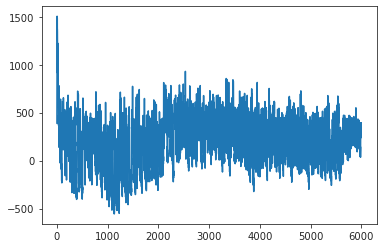

In [137]:
plt.plot(base.data[70])

### Anim = 5

In [141]:
key = mice.get_key(5, 3, 1)
base = Base(mice, key=key, mode='ca2', prep_data=True)

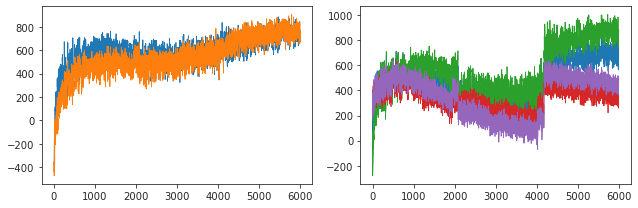

In [206]:
fig, axes = create_figure(1, 2, (9, 3))
axes[0].plot(base.data[[74, 75]].T, alpha=1, lw=0.8)
axes[1].plot(base.data[[70, 71, 72, 73, 76]].T, alpha=1, lw=0.8)

plt.show()

In [249]:
aaa = dict(np.array(list(base.n2l.items()))[70:77])
aaa

{
    '70': '1-117-0',
    '71': '1-118-0',
    '72': '1-119-0',
    '73': '1-121-0',
    '74': '1-122-0',
    '75': '1-123-0',
    '76': '1-125-0'
}

In [250]:
bbb = {
    int(n): mice.parcel.encode(lbl)
    for n, lbl in aaa.items()
}
bbb

{70: 117, 71: 118, 72: 119, 73: 121, 74: 122, 75: 123, 76: 125}

In [238]:
from register.register import Register
reg = Register(mice)
reg.set_mode('ca2')

In [239]:
key = mice.get_key(5, 3)
obj = reg.load_obj_masks(key)
x = obj['cols'].numpy()

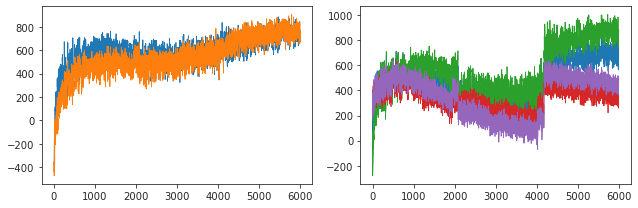

In [242]:
fig, axes = create_figure(1, 2, (9, 3))
axes[0].plot(base.data[[74, 75]].T, alpha=1, lw=0.8)
axes[1].plot(base.data[[70, 71, 72, 73, 76]].T, alpha=1, lw=0.8)

plt.show()

In [251]:
bbb

{70: 117, 71: 118, 72: 119, 73: 121, 74: 122, 75: 123, 76: 125}

<matplotlib.image.AxesImage object at 0x7f94cb0dda90>

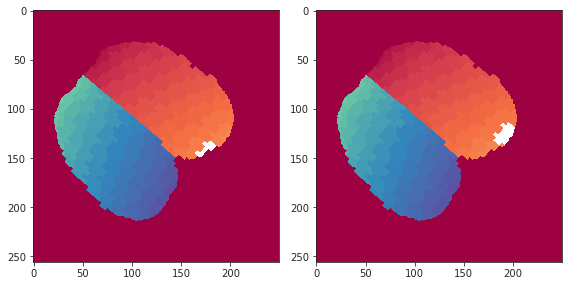

In [260]:
fig, axes = create_figure(1, 2, (8, 4))
axes[0].imshow(mwh(np.isin(x, [bbb[i] for i in [74, 75]]), x), cmap='Spectral')
axes[1].imshow(mwh(np.isin(x, [bbb[i] for i in [70, 71, 72, 73, 76]]), x), cmap='Spectral')

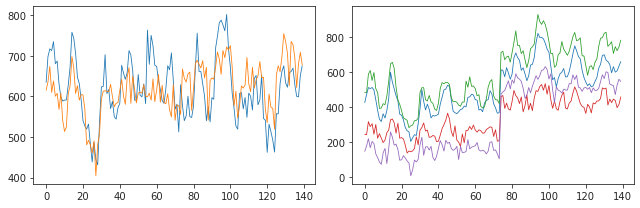

In [265]:
fig, axes = create_figure(1, 2, (9, 3))
axes[0].plot(base.data[[74, 75]][:, 4100:4240].T, alpha=1, lw=0.8)
axes[1].plot(base.data[[70, 71, 72, 73, 76]][:, 4100:4240].T, alpha=1, lw=0.8)

plt.show()

In [278]:
f = 'sub-SLC05_ses-3_task-rest_run-1_space-individual_desc-preproc_ca2.nii.gz'
f = pjoin(mice.cfg.raw_dir, f)
img = ants.image_read(f)

In [279]:
x = img.numpy()[..., 4178 - 30:4178 + 31]
x.shape

(256, 250, 1, 61)

In [280]:
from register.register import reset_ants_img
img = reset_ants_img(x, img.spacing, img.origin, img.dtype, use_um=False)

In [281]:
ants.image_write(img, pjoin(tmp_dir, f'{key}_run-1_ca_cut.nii.gz'))

In [282]:
4178 - 30, 4178 + 31

(4148, 4209)